In [1]:
# Importando o framework para predição das imagens
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
# Importando bibliotecas para analises de imagens
import cv2
import imgaug as im
from PIL import Image

# Importando bibliotecas do sistema
import os
import base64

# Importa biblioteca para rede neural
import keras
import segmentation_models as sm

# Importa bibliotecas para analise de dados
import pandas as pd
import numpy as np

# Importa bibliotecas para visualização de dataframes com imagens
import pdfkit as pdf
from io import BytesIO
from IPython.display import HTML


Segmentation Models: using `tf.keras` framework.


In [3]:
path_name_image = 'D:/Sensix/Python/img_generated/img_original/1874/rgb/'
path_name_image_md = 'D:/Sensix/Python/img_generated/img_original/1874/ground-truth/'

model = sm.Linknet('vgg16', encoder_weights='imagenet')
model_2 = sm.Linknet('vgg16', encoder_weights='imagenet')
model_3 = sm.Linknet('vgg16', encoder_weights='imagenet')

model.load_weights('D:/Sensix/Python/Redes Neurais/diverses_backbones/segment_weed_2.h5')
model_2.load_weights('D:/Sensix/Python/Redes Neurais/marcacoes_externas/vgg16_Linknet_2.hdf5')
model_3.load_weights('D:/Sensix/Python/Redes Neurais/marcacoes_filtro_verde/vgg16_Linknet_Test13.hdf5')

In [4]:
original_img = []
name_model = ['model','model_2', 'model_3']
dir_save = ['pred_0/','pred_1/', 'pred_2/']

save_dir = 'D:/Sensix/Python/img_generated/imgs_pred/1874/'
save_dir_md = 'D:/Sensix/Python/img_generated/img_original/1874/ground-truth_rgb/'

In [5]:

for name_image, i in zip(os.listdir(path_name_image), range(30)):
    image_rgb = cv2.imread(path_name_image + name_image)
    image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB) / 255
    original_img.append(image_rgb)
    predictions = []
    
    for i in range(3): 
        image = image_rgb.copy()
        pred = eval(str(name_model[i]) + '.predict(np.array([image_rgb]))[0]')
        pred = np.array(pred)
        pred = pred[:,:,0]

        pred[pred > 0.1] = 1
        pred[pred < 0.1] = 0
        
        image[pred == 1] = [255,0,0]
        image = image.astype('float32')
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = image * 255
        
        predictions.append(pred)
        
        cv2.imwrite(save_dir + dir_save[i] + name_image, image)
        
        del pred, image

In [6]:
for name_image_md, i in zip(os.listdir(path_name_image_md), range(len(original_img))):
    image_rgb = cv2.imread(path_name_image_md + name_image_md)
    
    image = image_rgb.copy()
    image = np.array(image)
    image = image[:,:,0]

    image[image < 1 ] = 0
    image[image >= 1] = 1
    real_img = original_img[i]
        
    real_img[image == 1] = [255,0,0]
    real_img = real_img.astype('float32')
    real_img = cv2.cvtColor(real_img, cv2.COLOR_RGB2BGR)
    real_img = real_img * 255
        
    cv2.imwrite(save_dir_md + name_image_md, real_img)

In [7]:
def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [8]:
dict_predict_images = {}
name_collums = ['path_imgs', 'path_marked', 'path_model', 'path_model_2', 'path_model_3']

dir_images = 'D:/Sensix/Python/img_generated/img_original/1874/rgb/'

path_marked = 'D:/Sensix/Python/img_generated/img_original/1874/ground-truth_rgb/'
path_model = 'D:/Sensix/Python/img_generated/imgs_pred/1874/pred_0/'
path_model_2 = 'D:/Sensix/Python/img_generated/imgs_pred/1874/pred_1/'
path_model_3 = 'D:/Sensix/Python/img_generated/imgs_pred/1874/pred_2/'

In [9]:
for i in range(len(name_collums)):
    dict_predict_images[name_collums[i]] = []

In [10]:
for name_image in os.listdir(path_name_image):
    dict_predict_images['path_imgs'].append(str(dir_images) + str(name_image))
    dict_predict_images['path_marked'].append(str(path_marked) + str(name_image))
    dict_predict_images['path_model'].append(str(path_model) + str(name_image))
    dict_predict_images['path_model_2'].append(str(path_model_2) + str(name_image))
    dict_predict_images['path_model_3'].append(str(path_model_3) + str(name_image))

In [11]:
df = pd.DataFrame(dict_predict_images)

In [12]:
df['imgs'] = df.path_imgs.map(lambda f: get_thumbnail(f))
df['imgs_marked'] = df.path_marked.map(lambda f: get_thumbnail(f))
df['model'] = df.path_model.map(lambda f: get_thumbnail(f))
df['model_2'] = df.path_model_2.map(lambda f: get_thumbnail(f))
df['model_3'] = df.path_model_3.map(lambda f: get_thumbnail(f))

,imgs,imgs_marked,model,model_2,model_3
0,,,,,
1,,,,,
2,,,,,
3,,,,,
4,,,,,
5,,,,,
6,,,,,
7,,,,,
8,,,,,
9,,,,,

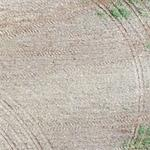
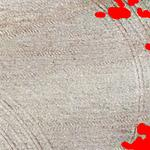
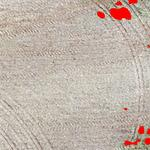
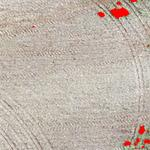
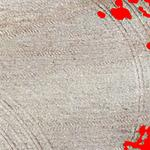
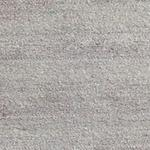
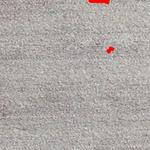
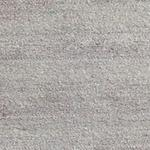
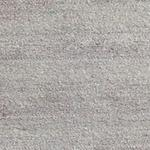
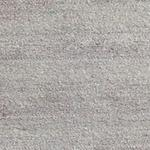
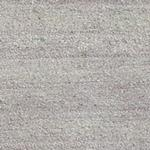
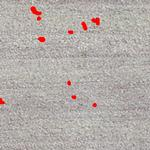
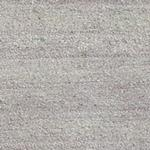
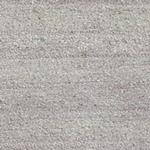
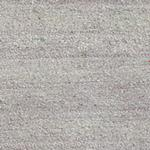
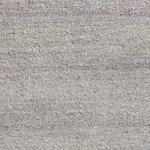
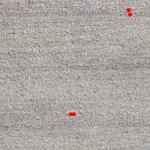
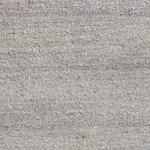
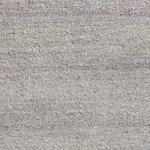
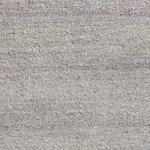
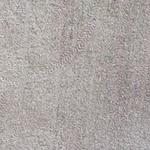
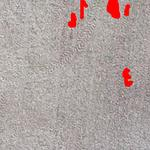
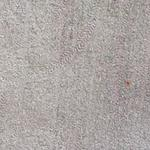
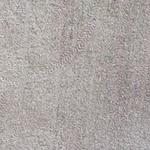
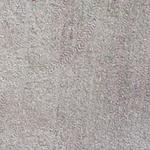
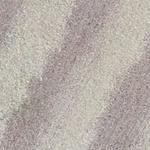
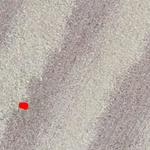
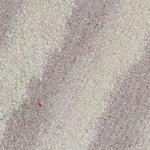
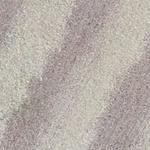
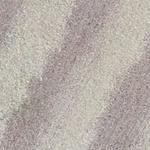
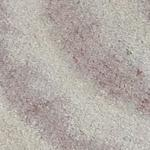
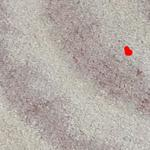
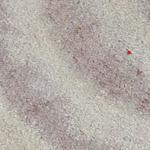
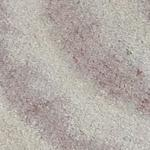
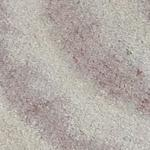
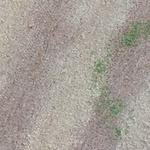
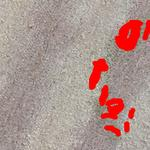
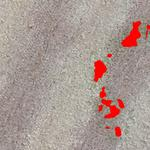
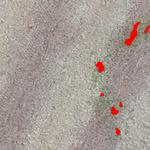
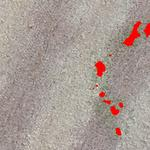
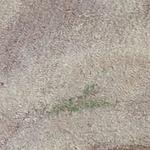
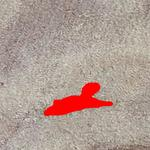
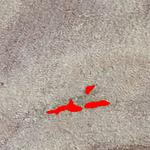
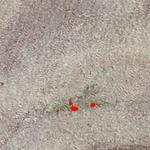
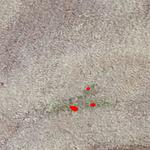
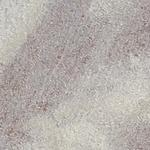
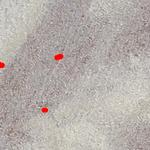
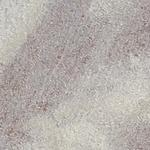
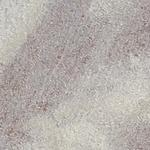
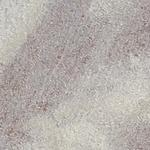
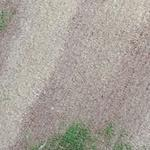
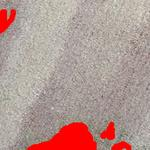
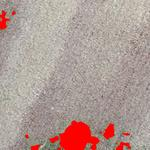
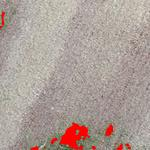
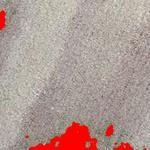
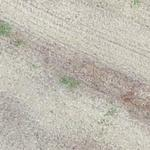
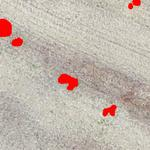
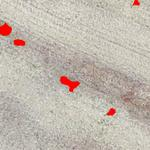
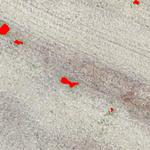
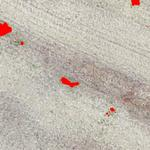
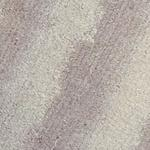
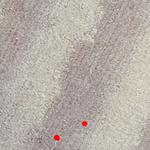
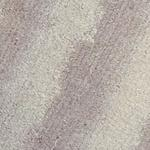
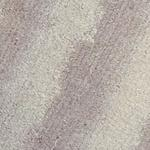
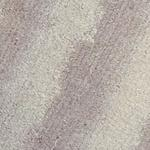
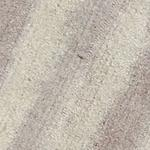
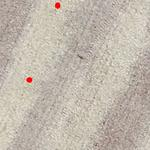
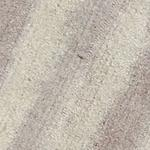
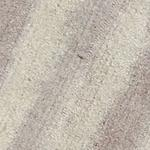
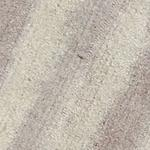
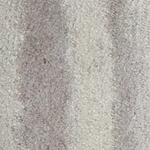
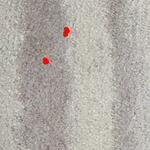
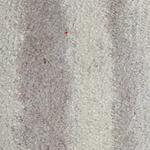
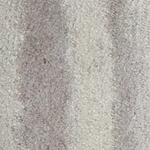
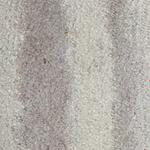
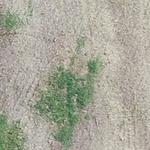
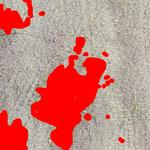
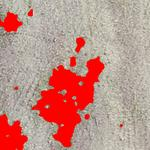
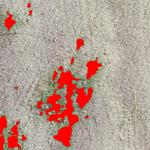
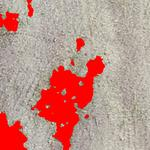
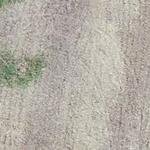
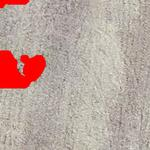
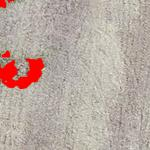
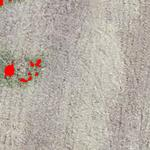
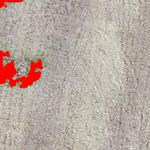
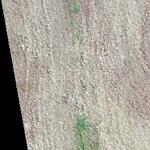
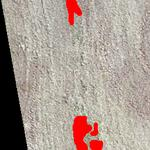
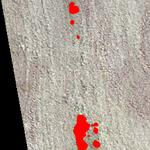
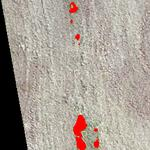
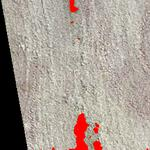
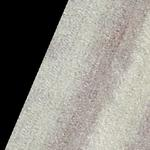
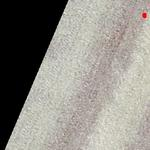
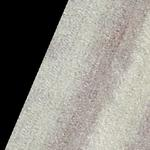
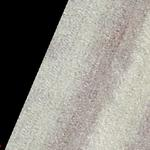
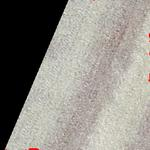
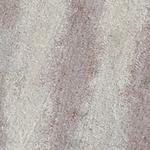
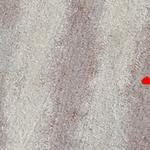
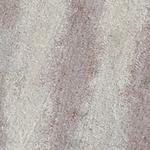
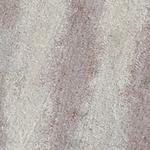
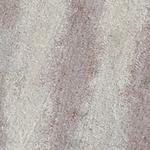
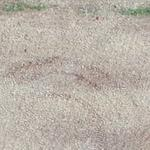
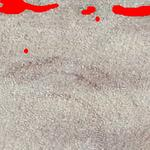
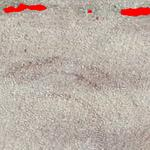
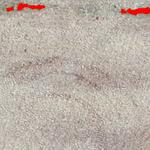
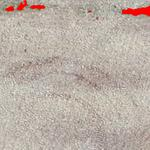
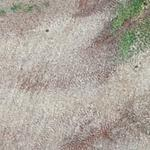
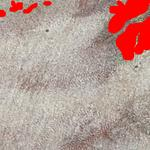
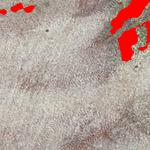
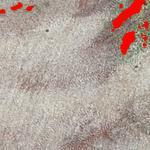
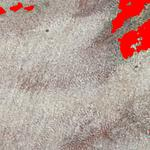
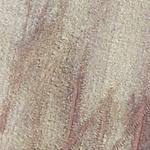
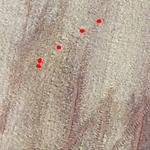
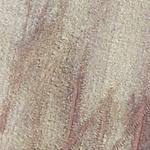
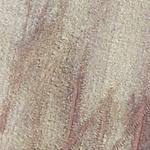
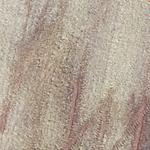
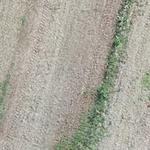
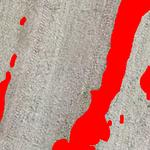
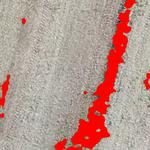
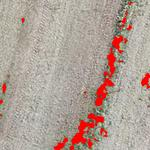
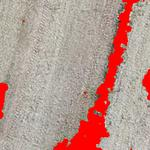
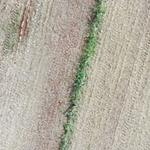
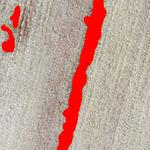
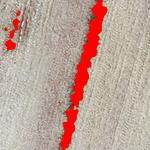
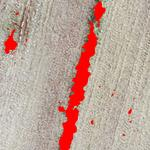
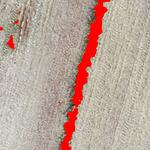
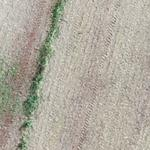
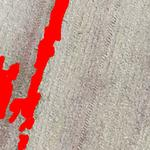
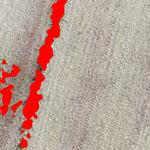
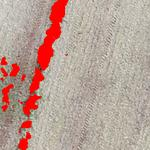
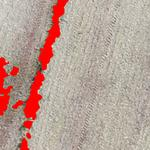
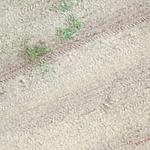
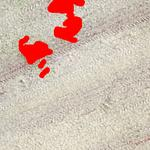
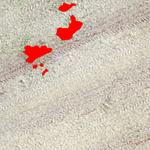
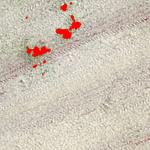
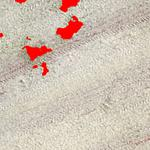
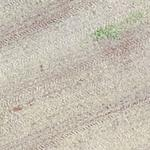
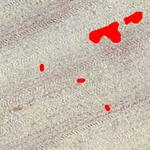
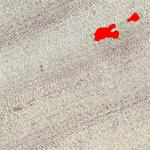
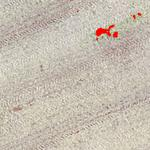
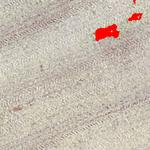
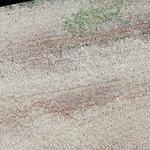
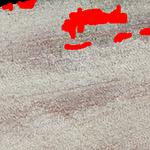
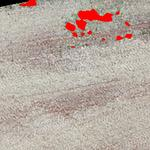
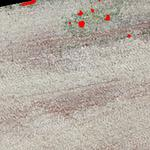
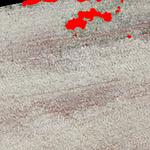
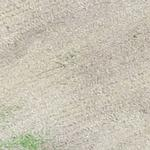
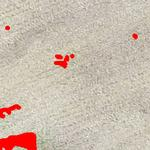
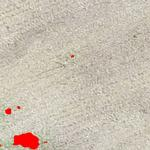
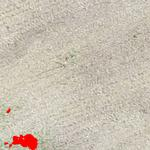
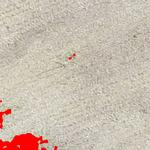

In [13]:
table = HTML(df[['imgs', 'imgs_marked',
                 'model', 
                 'model_2', 
                 'model_3']].to_html(#'table.html', 
                                         formatters={'imgs': image_formatter,
                                         'imgs_marked': image_formatter,
                                         'model': image_formatter,
                                         'model_2': image_formatter,
                                         'model_3': image_formatter},
                                         escape=False))

#pdf.from_file('table.html', 'table.pdf')
table